In [17]:
# Internal imports
import os
import pickle

# External imports
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import corner
import seaborn as sns
sns.set_theme()
import arviz as az

import emcee
# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

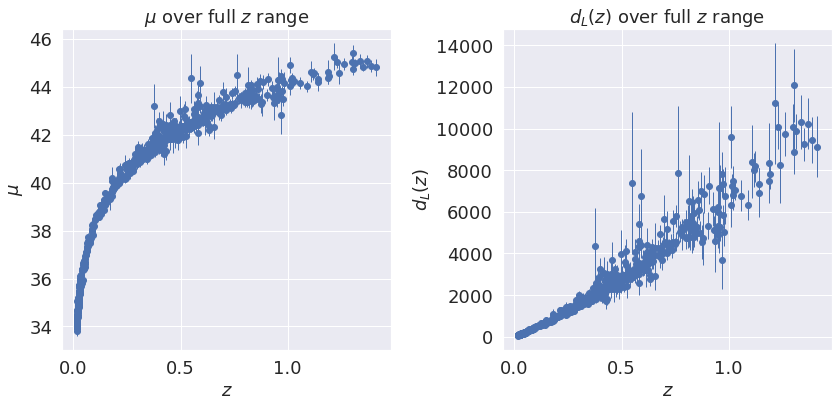

In [18]:
### Imported data
z = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 1)
mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 2)
delta_mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 3)
data4 = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 4)

### Sort data for increasing z
sortOrder = np.argsort(z)
z = z[sortOrder]
mu = mu[sortOrder]
delta_mu = delta_mu[sortOrder]
dl = 10**(mu/5-5) # Extract dl(z) from modulus
delta_dl = dl*np.log(10)*delta_mu/5

### Plot the data
fig,ax = plt.subplots(1,2, figsize = (12,6))
ax[0].scatter(z,mu)
ax[0].errorbar(z,mu,delta_mu, linewidth = 0, elinewidth = 1)
ax[0].set_title(r'$\mu$ over full $z$ range')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$\mu$')


ax[1].scatter(z,dl)
ax[1].errorbar(z,dl,delta_dl, linewidth = 0, elinewidth = 1)

ax[1].set_title(r'$d_L(z)$ over full $z$ range')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$d_L(z)$')

plt.tight_layout()

#### Define models

/home/ericl/miniconda3/envs/physics/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


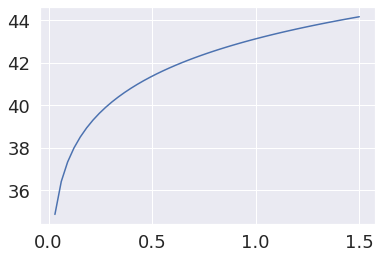

In [19]:
c = 299792458
H0 = 70000
w = 1
def lambda_CDM(z, Omega_M, Omega_Lambda):
    dl_z = np.zeros(len(z))
    for i, zi in enumerate(z):
        z_prim = np.linspace(0, zi, 100)
        Ez_prim = Omega_M * (1+z_prim)**3 + Omega_Lambda
        Hz_prim = H0 * np.sqrt(Ez_prim)
        dl_z[i] = c*(1+zi) * np.trapz(y=1/Hz_prim, x=z_prim)
    mu_z = np.log10(dl_z)*5 + 25
    return mu_z

def omega_CDM(z, Omega_M, Omega_Lambda, omega):
    dl_z = np.zeros(len(z))
    for i, zi in enumerate(z):
        z_prim = np.linspace(0, zi, 100)
        Ez_prim = Omega_M * (1+z_prim)**3 + Omega_Lambda*(1+z_prim)**(3*(1+omega))
        Hz_prim = H0 * np.sqrt(Ez_prim)
        dl_z[i] = c*(1+zi) * np.trapz(y=1/Hz_prim, x=z_prim)
    mu_z = np.log10(dl_z)*5 + 25
    return mu_z

z_test = np.linspace(0,1.5)
mu_test = lambda_CDM(z_test, 1,1)
plt.plot(z_test, mu_test)

#### Emcee setup

In [20]:
# Log Priors
def log_prior(theta):
    Omega_M, Omega_lambda = theta
    if 0.0 < Omega_M < 1 and 0.0 < Omega_lambda < 1.0:
        return 0.0
    return -np.inf

def log_omega_prior(theta):
    Omega_M, Omega_lambda, omega = theta
    if 0.0 < Omega_M < 1 and 0.0 < Omega_lambda < 1.0 and -np.inf < omega < np.inf:
        return 0.0
    return -np.inf

# Log Likelihoods
def log_lambda_likelihood(theta, z, mu, mu_err):
    # Use data weights equal to the measurement variance - i.e. set scale to 1 (known)
    W = np.diag(mu_err**(-2))
    Omega_M, Omega_lambda = theta
    mu_z = lambda_CDM(z, Omega_M, Omega_lambda)
    if np.any(np.isnan(mu_z)):
        return -np.inf
    
    normalization = - 0.5*(np.log(2*np.pi)*len(z) + np.sum(2*np.log(mu_err)) )
    return -0.5*(mu-mu_z)@W@(mu-mu_z) + normalization

def log_omega_likelihood(theta, z, mu, mu_err):
    # Use data weights equal to the measurement variance - i.e. set scale to 1 (known)
    W = np.diag(mu_err**(-2))
    Omega_M, Omega_lambda, w = theta
    mu_z = omega_CDM(z, Omega_M, Omega_lambda, w)
    if np.any(np.isnan(mu_z)):
        return -np.inf
    normalization = - 0.5*(np.log(2*np.pi)*len(z) + np.sum(2*np.log(mu_err)) )
    return -0.5*(mu-mu_z)@W@(mu-mu_z) + normalization

def log_omega_likelihood_known_omega(theta, z, mu, mu_err, w):
    # Use data weights equal to the measurement variance - i.e. set scale to 1 (known)
    W = np.diag(mu_err**(-2))
    Omega_M, Omega_lambda = theta
    mu_z = omega_CDM(z, Omega_M, Omega_lambda, w) 
    if np.any(np.isnan(mu_z)):
        return -np.inf
    normalization = - 0.5*(np.log(2*np.pi)*len(z) + np.sum(2*np.log(mu_err)) )
    return -0.5*(mu-mu_z)@W@(mu-mu_z) + normalization

# Log posterior
def log_lambda_posterior(theta, z, mu, mu_err):
    return log_lambda_likelihood(theta, z, mu, mu_err) + log_prior(theta)

def log_omega_posterior(theta, z, mu, mu_err):
    return log_omega_likelihood(theta, z, mu, mu_err) + log_omega_prior(theta)

def log_omega_posterior_known_omega(theta, z, mu, mu_err, w):
    return log_omega_likelihood_known_omega(theta, z, dl, mu_err, w) + log_prior(theta)

log_lambda_likelihood((0.3, 0.7), z, mu, delta_mu)
log_omega_likelihood((0.3, 0.7, -1.11581788), z, mu, delta_mu)

116.78396452122485

In [21]:
nll_lambda = lambda *args: -log_lambda_likelihood(*args)
nll_omega = lambda *args: -log_omega_likelihood(*args)
nll_omega_known_omega = lambda *args: -log_omega_likelihood_known_omega(*args)

theta_hat_lambda = sc.optimize.minimize(nll_lambda, [0.5,0.5], args=(z, mu, delta_mu), bounds = ((1e-5,10),(1e-5,10)))
theta_hat_omega = sc.optimize.minimize(nll_omega, [0.5,0.5, -1], args=(z, mu, delta_mu), bounds = ((1e-5,10),(1e-5,10),(-np.inf, np.inf)))
theta_hat_omega_known_omega = sc.optimize.minimize(nll_omega_known_omega, [0.5,0.5], args=(z, mu, delta_mu, -1.11581788), bounds = ((1e-5,10),(1e-5,10)))
max_likelihood_lambda = -theta_hat_lambda.fun
max_likelihood_omega = -theta_hat_omega.fun
max_likelihood_known_omega = -theta_hat_omega_known_omega.fun

print(max_likelihood_lambda)
print(max_likelihood_omega)
print(theta_hat_lambda.x)
print(theta_hat_omega.x)
print(theta_hat_omega_known_omega.x)

118.74028686294741
118.74149868264095
[0.2776323  0.72243639]
[ 0.28131892  0.71920664 -1.00990845]
[0.316914   0.68835805]


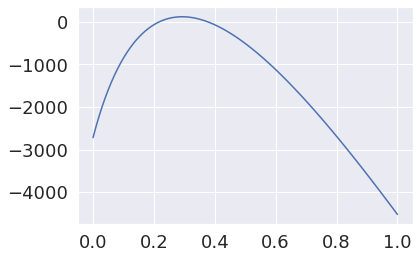

In [22]:
Omega = np.linspace(0,1,100)
theta = np.zeros(len(Omega))
for i, w in enumerate(Omega):
    theta[i] = log_lambda_likelihood((w,0.7), z, mu,delta_mu)
plt.plot(Omega,theta)

In [23]:
def bic(log_L_max, len_data, len_params):
    return 2*log_L_max - len_params*np.log(len_data)

def aic(log_L_max, len_params):
    return 2*log_L_max - 2*len_params

# Lambda model
lambda_bic = bic(max_likelihood_lambda, len(z), 2)
lambda_aic = aic(max_likelihood_lambda, 2)

print(f'Lambda model\n\tBIC={lambda_bic:.2f} \t AIC={lambda_aic:.2f}')

# Omega model
omega_bic = bic(max_likelihood_omega, len(z), 3)
omega_aic = aic(max_likelihood_omega, 3)

print(f'Omega model\n\tBIC={omega_bic:.2f} \t AIC={omega_aic:.2f}')

# Known omega
omega_bic_known = bic(max_likelihood_known_omega, len(z), 2)
omega_aic_known = aic(max_likelihood_known_omega, 2)

print(f'Known omega\n\tBIC={omega_bic_known:.2f} \t AIC={omega_aic_known:.2f}')

Lambda model
	BIC=224.75 	 AIC=233.48
Omega model
	BIC=218.39 	 AIC=231.48
Known omega
	BIC=224.50 	 AIC=233.22


#### Calculate central values
Do this by emcee sampling posterior.

In [24]:
n_walkers = 6
burn_in = 1000
n_samples = 20000

In [25]:
# Lambda model
n_dim = 2
initial = np.random.rand(n_walkers, n_dim)
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_lambda_posterior, args=(z, mu, delta_mu))


if(os.path.isfile('trace_lambda_task2.p')):
    print('Using pickled trace')
    trace_lambda = pickle.load( open( 'trace_lambda_task2.p', 'rb' ) )
else:
    print('No trace file found. Running MCMC for lambda model')
    # Run burn in
    sampler.run_mcmc(initial, burn_in)
    final_state = sampler.get_last_sample()
    # Sample posterior
    sampler.reset()
    sampler.run_mcmc(final_state, n_samples)
    print(sampler.acceptance_fraction)
    trace_lambda = sampler.get_chain()
    pickle.dump(trace_lambda, open( "trace_lambda_task2.p", "wb" ))

Using pickled trace


In [26]:
# Omega model
n_dim = 3
initial = np.random.rand(n_walkers, n_dim)
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_omega_posterior, args=(z, mu, delta_mu))

if(os.path.isfile('trace_omega_task2.p')):
    print('Using pickled trace')
    trace_omega = pickle.load( open( 'trace_omega_task2.p', 'rb' ) )
else:
    print('No trace file found. Running MCMC for omega model')
    # Run burn in
    sampler.run_mcmc(initial, burn_in)
    final_state = sampler.get_last_sample()
    # Sample posterior
    sampler.reset()
    res = sampler.run_mcmc(final_state, n_samples)
    trace_omega = sampler.get_chain()
    print(sampler.acceptance_fraction)
    pickle.dump(trace_omega, open( "trace_omega_task2.p", "wb" ))

Using pickled trace


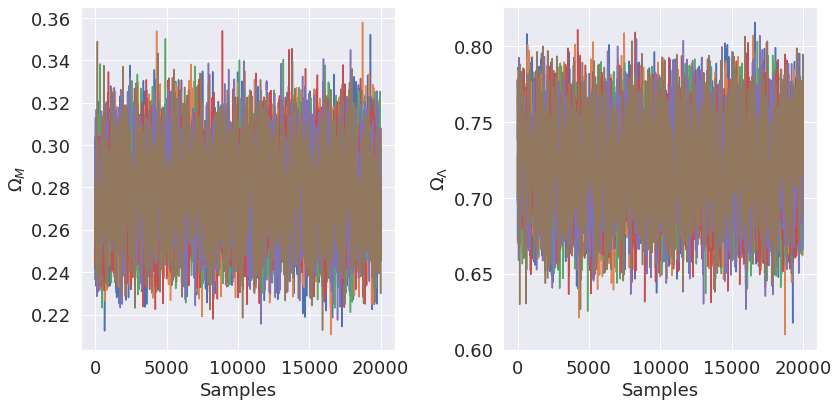

In [27]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
for i in range(trace_lambda.shape[2]):
    for j in range(trace_lambda.shape[1]):
        axs[i].plot(trace_lambda[:, j,i])
axs[0].set_xlabel('Samples')
axs[1].set_xlabel('Samples')

axs[0].set_ylabel(r'$\Omega_M$')
axs[1].set_ylabel(r'$\Omega_{\Lambda}$')
plt.tight_layout()

#### Calculate central values: mean, mode, median

In [28]:
# lambda model
# Use Scipy to maximize the posterior to get the mode
lambda_trace = np.concatenate(trace_lambda, axis=0)
nll_lambda = lambda *args: -log_lambda_posterior(*args)
theta_hat_lamda = sc.optimize.minimize(nll_lambda, [0.5,0.5], args=(z, mu, delta_mu), bounds = ((1e-5,10),(1e-5,10)))

lambda_omega_m_mean = np.mean(lambda_trace[:,0])
lambda_omega_l_mean = np.mean(lambda_trace[:,1])

lambda_omega_m_mode = theta_hat_lambda.x[0]
lambda_omega_l_mode = theta_hat_lambda.x[1]

lambda_omega_m_median = np.median(lambda_trace[:,0])
lambda_omega_l_median = np.median(lambda_trace[:,1])

print(f'Lambda model\n\t Mean: Omega_M = {lambda_omega_m_mean:.6f} \t Omega_l = {lambda_omega_l_mean:.6f}\
\n\t Mode: Omega_M = {lambda_omega_m_mode:.6f} \t Omega_l = {lambda_omega_l_mode:.6f}\
\n\t Median: Omega_M = {lambda_omega_m_median:.6f} \t Omega_l = {lambda_omega_l_median:.6f}')

Lambda model
	 Mean: Omega_M = 0.278158 	 Omega_l = 0.721863
	 Mode: Omega_M = 0.277632 	 Omega_l = 0.722436
	 Median: Omega_M = 0.278132 	 Omega_l = 0.721926


#### Extract the posterior for $\Omega_M$

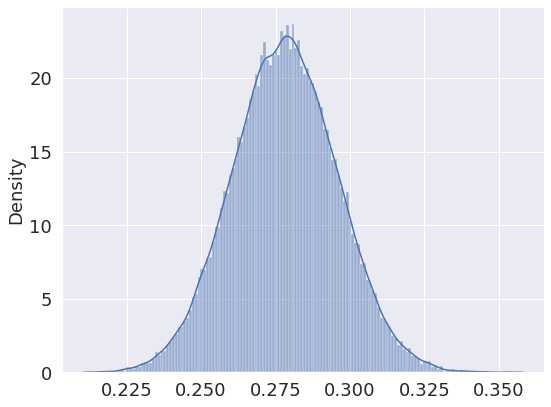

In [29]:
omega_m_post = lambda_trace[:,0]
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=omega_m_post, kde=True, stat='density', ax=ax)

plt.tight_layout()
plt.savefig('figures_task2/omega_m_posterior.png')

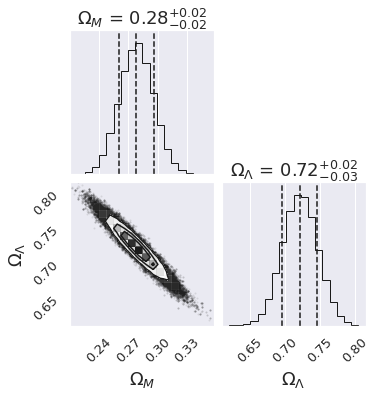

In [30]:
# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig_corner = corner.corner(lambda_trace,labels =[r'$\Omega_M$', '$\Omega_\Lambda$'], show_titles=True, quantiles=[0.16, 0.5, 0.84]);
plt.savefig('figures_task2/corner.png')

In [32]:
print(lambda_trace.shape)
s = 100
def calc_log_marg(trace, posterior_func, s):
    posterior = np.zeros((s))
    for i, tr in enumerate(trace):
        if i == s:
            break
        posterior[i] = posterior_func(tr, z, mu, delta_mu)

    m_post = np.max(posterior)

    marg = 1/s * np.exp(m_post)*np.sum( np.exp( posterior-m_post ) )
    log_marg = m_post + np.log(np.sum(np.exp(posterior-m_post))) - np.log(s)
    return log_marg



omega_trace = np.concatenate(trace_omega, axis=0)

log_marg_lambda = calc_log_marg(lambda_trace, log_lambda_posterior, s)
log_marg_omega = calc_log_marg(omega_trace, log_omega_posterior, s)

(120000, 2)


In [33]:
print(log_marg_lambda)
print(log_marg_omega)

117.95703180726602
117.95115765642993
